In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  # преобразование данных
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [37]:
def initOptims(SGD, AdaDelta, NAG, Adam):
    return [
        {"name": "SGD", "optim": SGD},
        {"name": "AdaDelta", "optim": AdaDelta},
        {"name": "NAG", "optim": NAG},
        {"name": "Adam", "optim": Adam},
    ]

### LeNet

SGD:
Точность без обучения: 9.97%
Эпоха: 1, Потери: 1.9739445379293803
Эпоха: 2, Потери: 0.35786409284482634
Эпоха: 3, Потери: 0.1708103749476103
Эпоха: 4, Потери: 0.12382935377945906
Эпоха: 5, Потери: 0.10227264949420431
Точность SGD: 96.36%
Время обучения: 99.69276857376099

AdaDelta:
Точность без обучения: 10.46%
Эпоха: 1, Потери: 0.18554634833174732
Эпоха: 2, Потери: 0.0514452314237443
Эпоха: 3, Потери: 0.03918498969453919
Эпоха: 4, Потери: 0.030175421217965685
Эпоха: 5, Потери: 0.025417936833390855
Точность AdaDelta: 99.04%
Время обучения: 102.99060273170471

NAG:
Точность без обучения: 11.37%
Эпоха: 1, Потери: 1.9466710982800546
Эпоха: 2, Потери: 0.3802718737486329
Эпоха: 3, Потери: 0.1740475314885759
Эпоха: 4, Потери: 0.12299455536195814
Эпоха: 5, Потери: 0.09978748927079538
Точность NAG: 97.53%
Время обучения: 102.92114734649658

Adam:
Точность без обучения: 13.05%
Эпоха: 1, Потери: 0.2573568878277366
Эпоха: 2, Потери: 0.07407054826537811
Эпоха: 3, Потери: 0.050396424827542204


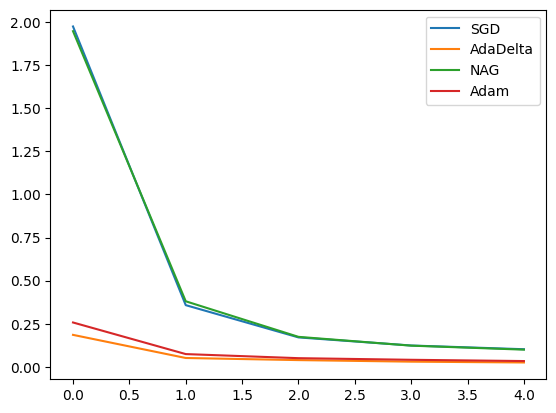

In [49]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 256)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

criterion = nn.CrossEntropyLoss()

def countAccuracy():
    correct = 0
    for image, label in testset:
        outputs = net(image)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted == label
    return 100 * correct.item() / len(testset)

def train(optimizer, optim_name):
    print(f"{optim_name}:")
    print(f"Точность без обучения: {countAccuracy():.2f}%")
    start_time = time.time()
    xs, ys = [], []
    for epoch in range(5):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        xs.append(epoch)
        ys.append(running_loss / len(trainloader))
        print(f'Эпоха: {epoch + 1}, Потери: {ys[-1]}')
    plt.plot(xs, ys, label = optim_name)
    print(f"Точность {optim_name}: {countAccuracy():.2f}%")
    print(f"Время обучения: {time.time() - start_time} с\n")

net = LeNet()
SGD = optim.SGD(net.parameters(), lr=0.01)
train(SGD, "SGD")
net = LeNet()
AdaDelta = optim.Adadelta(net.parameters(), lr=1.0)
train(AdaDelta, "AdaDelta")
net = LeNet()
NAG = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True)
train(NAG, "NAG")
net = LeNet()
Adam = optim.Adam(net.parameters(), lr=0.001)
train(Adam, "Adam")

plt.legend()
plt.show()